## Session 12 - PyTorch Lightning & Gradio

### Import modules

In [1]:
import torch
import torch.nn as nn
import lightning as L
import torchvision
from lightning.pytorch.tuner import Tuner

In [2]:
# Import user defined modules
from models.resnet_lightning import ResNet
from utils.data import CIFARDataModule
from utils.config import config
from utils.common import get_misclassified_data, plot_misclassified
from utils.gradcam import plot_gradcam

### Import the Datamodule & Initialize

In [3]:
datamodule = CIFARDataModule()
datamodule.setup()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Configuration Parameters

In [4]:
batch_size = config.data.batch_size
shuffle = config.data.shuffle
num_workers = config.data.num_workers
learning_rate = config.training.lr
scheduler_steps = len(datamodule.train_dataloader())
maxlr = learning_rate
epochs = config.training.epochs

### Initialize Model & Trainer

In [5]:
model = ResNet(
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
    learning_rate=learning_rate,
    scheduler_steps=scheduler_steps,
    maxlr=maxlr,
    epochs=epochs,
)

trainer = L.Trainer(accelerator="gpu", devices=[0], num_nodes=1, max_epochs=epochs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Find the best learning rate

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/ravi.naik/learning/era/s12/submission/lightning_logs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ravi.naik/miniconda3/envs/torchenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0009120108393559097
Restoring states from the checkpoint path at /home/ravi.naik/learning/era/s12/submission/.lr_find_3e49ffd9-3bd5-4a38-95df-d2b20646244a.ckpt
Restored all states from the checkpoint at /home/ravi.naik/learning/era/s12/submission/.lr_find_3e49ffd9-3bd5-4a38-95df-d2b20646244a.ckpt


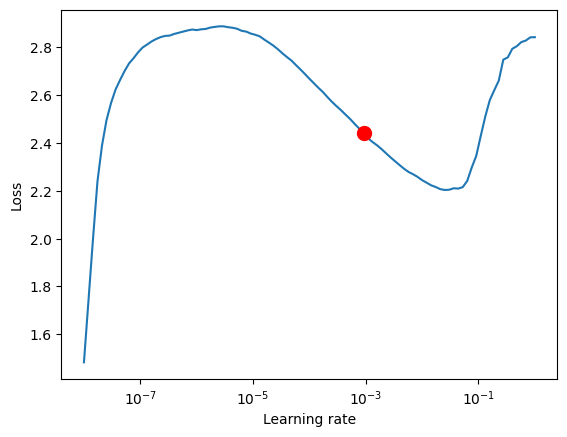

In [6]:
tuner = Tuner(trainer)

lr_finder = tuner.lr_find(model=model, datamodule=datamodule)
maxlr = lr_finder.suggestion()
fig = lr_finder.plot(suggest=True)

### Updated the optimum LR & Begin training

In [7]:
model.learning_rate = maxlr
model.maxlr = maxlr

trainer.fit(model, datamodule)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type               | Params
------------------------------------------------
0 | prep     | Sequential         | 1.9 K 
1 | layer1   | Sequential         | 369 K 
2 | layer2   | Sequential         | 295 K 
3 | layer3   | Sequential         | 5.9 M 
4 | pool     | MaxPool2d          | 0     
5 | fc       | Linear             | 5.1 K 
6 | softmax  | Softmax            | 0     
7 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.292    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


### Testing 

In [9]:
trainer.test(model, datamodule)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ravi.naik/miniconda3/envs/torchenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9190000295639038     │
│         test_loss         │    126.85746002197266     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 126.85746002197266, 'test_acc': 0.9190000295639038}]

In [12]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1845816), started 0:01:11 ago. (Use '!kill 1845816' to kill it.)

### Save model

In [13]:
trainer.save_checkpoint("model.ckpt")

### Load Model

In [14]:
model = ResNet.load_from_checkpoint("model.ckpt")

### Get misclassified data & Plot

In [15]:
misclassified_data = get_misclassified_data(
    model, "cpu", datamodule.test_dataloader(), 10
)

In [16]:
inv_normalize = torchvision.transforms.Normalize(
    mean=[-0.50 / 0.23, -0.50 / 0.23, -0.50 / 0.23], std=[1 / 0.23, 1 / 0.23, 1 / 0.23]
)

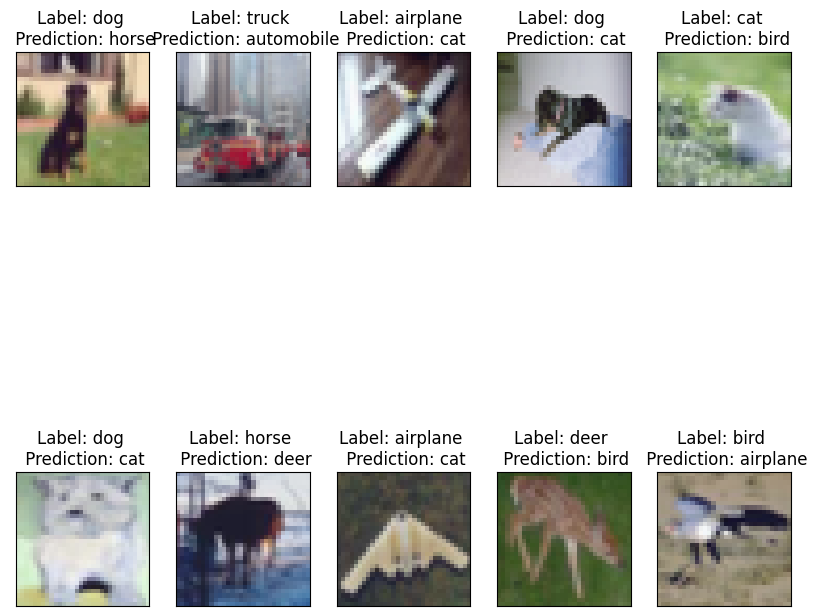

In [17]:
plot_misclassified(
    misclassified_data, datamodule.train_dataset.classes, inv_normalize=inv_normalize
)

### Generate Gradcam representation

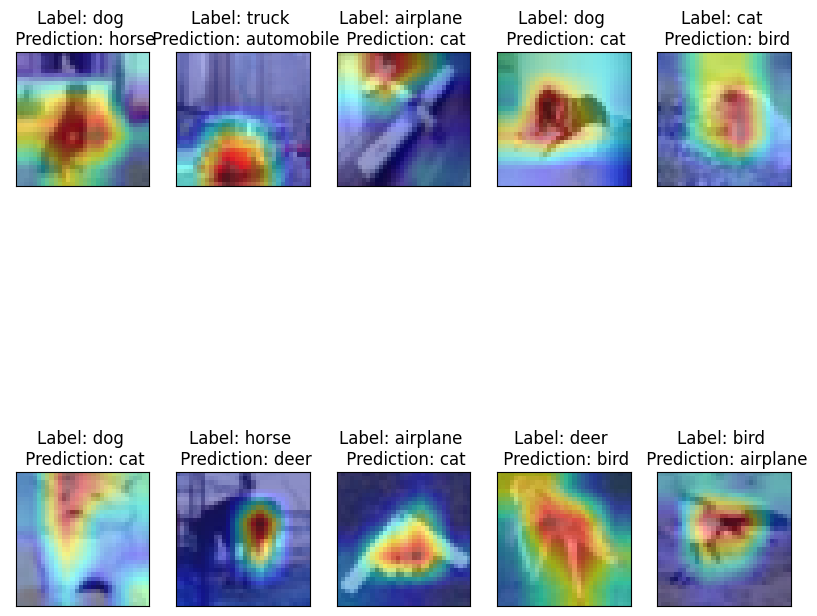

In [18]:
target_layers = [model.layer3[-1]]
targets = None
transparency = 0.60
number_of_samples = 10
data = misclassified_data
classes = datamodule.train_dataset.classes

plot_gradcam(model, data, classes, target_layers, 10, inv_normalize, cols=5)